In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.keras.backend.clear_session()

### dataset information

In [5]:
from datetime import datetime
dataset = 'mnist'
dims = (28,28,1)
umap_prop = 1.0
num_classes = 10
PROJECTION_DIMS = 1024
labels_per_class = 256 # 'full'
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = str(dataset) + '_' + str(umap_prop) + '_'  +  str(PROJECTION_DIMS)+ '_'  + str(labels_per_class) + '____' + datestring
print(datestring)

mnist_1.0_1024_256____2020_07_30_23_24_23_289415


### Load packages

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [7]:
from tfumap.load_datasets import load_MNIST, mask_labels

In [8]:
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_MNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [9]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build umap graph

In [10]:
from tfumap.semisupervised import build_fuzzy_simplicial_set

In [11]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    y=Y_masked,
    n_neighbors=n_neighbors,
)

### Build data iterators

In [12]:
from tfumap.umap import compute_cross_entropy, get_graph_elements
from tfumap.semisupervised import create_edge_iterator, create_validation_iterator, create_classification_iterator

In [13]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 1000])
batch_size

1000

In [14]:
# make sure batch size is no bigger than the number of labels per class
labeled_batch_size = batch_size if batch_size < len(Y_labeled) else len(Y_labeled)
labeled_iter = create_classification_iterator(X_labeled, Y_labeled, batch_size=batch_size)
print(labeled_batch_size)

1000


In [15]:
max_sample_repeats_per_epoch = 25
edge_iter, n_edges_per_epoch = create_edge_iterator(
    head,
    tail,
    weight,
    batch_size=batch_size,
    max_sample_repeats_per_epoch=max_sample_repeats_per_epoch,
)

In [16]:
data_valid, n_valid_samp = create_validation_iterator(X_valid, Y_valid, batch_size, repeat=True)

### Build network

In [17]:
encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.InputLayer(input_shape=dims))
encoder.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=3, strides=1, padding="same", activation="relu"
))
encoder.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=3, strides=1, padding="same", activation="relu"
))
encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
encoder.add(tf.keras.layers.Dropout(0.25))
encoder.add(tf.keras.layers.Flatten())
encoder.add(tf.keras.layers.Dense(units=128, activation="relu"))
encoder.add(tf.keras.layers.Dropout(0.25))

In [18]:
classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=128))
classifier.add(tf.keras.layers.Dense(units=128, activation="relu"))
classifier.add(tf.keras.layers.Dense(units=128, activation="relu"))
classifier.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="predictions"))

In [19]:
embedder = tf.keras.Sequential()
embedder.add(tf.keras.Input(shape=(128)))
embedder.add(tf.keras.layers.Dense(units=128, activation="relu"))
embedder.add(tf.keras.layers.Dense(units=128, activation="relu"))
embedder.add(tf.keras.layers.Dense(PROJECTION_DIMS, activation=None, name='z'))

In [20]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1605760   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

### Create UMAP object

In [21]:
from tfumap.semisupervised_model import PUMAP, compute_classifier_loss

In [22]:
import tensorflow as tf
from tfumap.umap import compute_cross_entropy, convert_distance_to_probability
from tfumap.semisupervised import (
    find_a_b,
    compute_umap_loss,
    # compute_classifier_loss,
    batch_data,
)
import numpy as np
import os, tempfile
from tqdm.autonotebook import tqdm
from datetime import datetime


@tf.function
def compute_classifier_loss(X, y, encoder, classifier, sparse_ce, acc_func):
    """ compute the cross entropy loss for classification
        """
    d = classifier(encoder(X))
    loss = sparse_ce(y, d)
    acc = acc_func(y, d)
    #acc = tf.keras.metrics.sparse_categorical_accuracy(y, d)
    return loss, acc


class PUMAP(tf.keras.Model):
    def __init__(
        self,
        encoder,
        embedder,
        classifier,
        tensorboard_logdir=None,  # directory for tensorboard log
        min_dist=0.1,
        negative_sample_rate=5.0,
        optimizer=tf.keras.optimizers.SGD(0.1),
        repulsion_strength=1.0,
        umap_prop=1.0,  # to what extent do we train UMAP
        # ** kwargs,
    ):
        super(PUMAP, self).__init__()
        # self.__dict__.update(kwargs)

        # subnetworks
        self.embedder = embedder
        self.encoder = encoder
        self.classifier = classifier

        self.umap_prop = umap_prop

        # optimizer for cross entropy minimization
        self.optimizer = optimizer
        self.repulsion_strength = repulsion_strength
        self.negative_sample_rate = negative_sample_rate

        # get a,b for current min_dist
        self._a, self._b = find_a_b(min_dist)

        # create summary writer to log loss information during training
        if tensorboard_logdir is None:
            self.tensorboard_logdir = os.path.join(
                tempfile.gettempdir(),
                "tensorboard",
                datetime.now().strftime("%Y%m%d-%H%M%S"),
            )
        else:
            self.tensorboard_logdir = tensorboard_logdir
        self.summary_writer_train = tf.summary.create_file_writer(
            self.tensorboard_logdir + "/train"
        )
        self.summary_writer_valid = tf.summary.create_file_writer(
            self.tensorboard_logdir + "/valid"
        )

        # sparse categorical cross entropy
        self.sparse_ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.class_acc = tf.keras.metrics.SparseCategoricalAccuracy()
        self.class_acc_val = tf.keras.metrics.SparseCategoricalAccuracy()

        # self.create_summary_metrics()

    @tf.function
    def train(self, batch_to, batch_from, X, y, save_loss=False):
        """ One training step 
        Input are points and weights for positive and negative 
        samples for training. 
            
        """
        if self.umap_prop > 0:
            with tf.GradientTape() as tape:

                (attraction_loss, repellant_loss, umap_loss) = compute_umap_loss(
                    batch_to,
                    batch_from,
                    self.embedder,
                    self.encoder,
                    self._a,
                    self._b,
                    self.negative_sample_rate,
                    self.repulsion_strength,
                )
            
                classifier_loss, classifier_acc = compute_classifier_loss(
                    X, y, self.encoder, self.classifier, self.sparse_ce, self.class_acc
                )
                loss = (
                    tf.reduce_mean(classifier_loss)
                    + tf.reduce_mean(umap_loss) * self.umap_prop
                )

            train_vars = (
                self.encoder.trainable_variables
                + self.embedder.trainable_variables
                + self.classifier.trainable_variables
            )
        else:  # ignore running costly UMAP computations if not training on UMAP loss
            with tf.GradientTape() as tape:
                classifier_loss, classifier_acc = compute_classifier_loss(
                    X, y, self.encoder, self.classifier, self.sparse_ce, self.class_acc
                )
                loss = classifier_loss
            train_vars = (
                self.encoder.trainable_variables + self.classifier.trainable_variables
            )
            attraction_loss = repellant_loss = umap_loss = 0

        # compute gradient for umap
        grad = tape.gradient(loss, train_vars)

        # gradients are cliped in UMAP implementation. Any effect here?
        grad = [tf.clip_by_value(grad, -4.0, 4.0) for grad in grad]

        self.optimizer.apply_gradients(zip(grad, train_vars))

        return (
            attraction_loss,
            repellant_loss,
            tf.reduce_mean(umap_loss),
            classifier_loss,
            classifier_acc,
        )

    @tf.function
    def write_losses(
        self,
        step,
        classifier_acc,
        classifier_loss,
        umap_loss,
        classifier_loss_val,
        classifier_acc_val,
    ):
        # write train loss
        with self.summary_writer_train.as_default():
            tf.summary.scalar(
                "classif_acc", classifier_acc, step=step,
            )
            tf.summary.scalar(
                "classif_loss", classifier_loss, step=step,
            )
            tf.summary.scalar(
                "umap_loss", umap_loss, step=step,
            )
            self.summary_writer_train.flush()
        # write valid loss
        with self.summary_writer_valid.as_default():
            tf.summary.scalar(
                "classif_acc", classifier_acc_val, step=step,
            )
            tf.summary.scalar(
                "classif_loss", classifier_loss_val, step=step,
            )
            self.summary_writer_valid.flush()



In [23]:
### Initialize model
model = PUMAP(
    min_dist = 0.0,
    negative_sample_rate = 5, # how many negative samples per positive
    optimizer=tf.keras.optimizers.Adam(1e-3), # cross-entropy optimizer
    encoder=encoder,
    embedder=embedder,
    classifier=classifier,
    umap_prop=umap_prop
    
)

### plotting results

In [24]:
from tfumap.semisupervised_plotting import plot_umap_classif_results, plot_results, get_decision_contour

No objects to concatenate


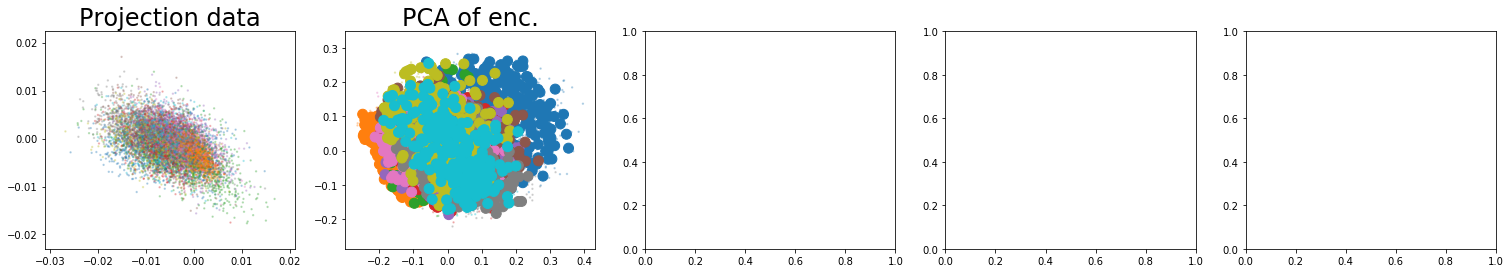

In [25]:
plot_umap_classif_results(model, X_valid, Y_valid, X_train, X_labeled, Y_labeled, batch_size, cmap='tab10', cmap2='tab10')

### Train model

In [26]:
from tfumap.paths import MODEL_DIR

In [27]:
batch = 0; epoch = 0
N_EPOCHS = 10
BATCHES_PER_EPOCH = int(n_edges_per_epoch / batch_size)

In [28]:
# early stopping parameters
patience = 10000 # wait this many batches without improvement before early stopping
min_delta = 0.0001 # threshold for what counts as an improvement
best_acc = 0 # the best current accuracy score
last_improvement = 0 # delta between current batch, and the last batch that was an improvement
best_saved_acc = 0 # best accuracy on valid data that has been checkpointed
best_saved_batch = 0 # batch number for last good batch
max_reinitialize_delta = .01 # minimum loss in accuracy resulting in reinitialized weights
plot_frequency = 2500 # how frequently to plot
save_frequency = 2500 # how frequently to save batches
early_stopping = False
# where to save checkpoints
cpt_path = MODEL_DIR / 'semisupervised' / dataset / datestring
# how often can we reload weights?
max_reloads = 10
n_reloads = 0

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/semisupervised_plotting.py:110: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale("log")


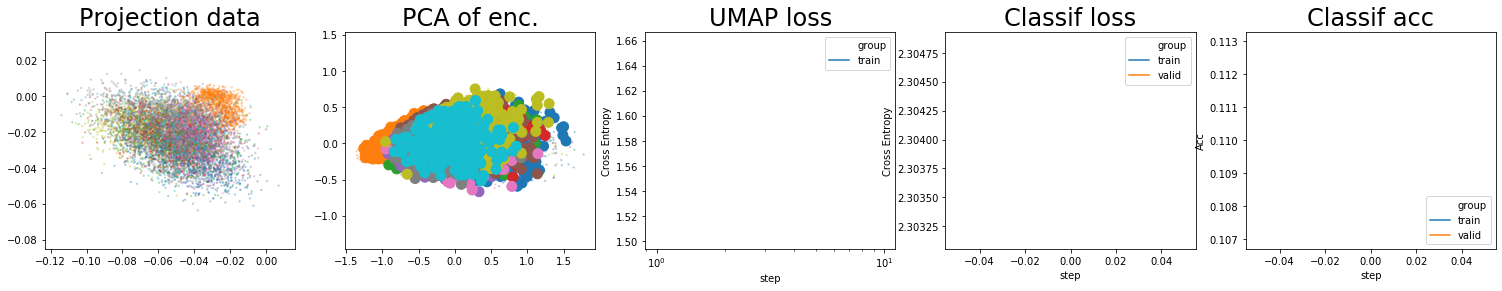

batch: 0 | train acc: 0.113 | val acc: 0.107
saving weights | batch = 0 | acc = 10


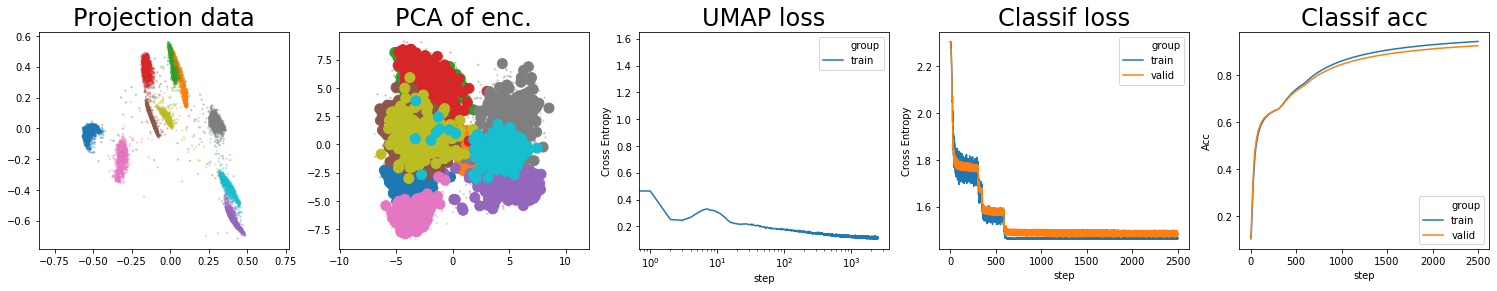

batch: 2500 | train acc: 0.9426 | val acc: 0.9245
saving weights | batch = 2500 | acc = 92


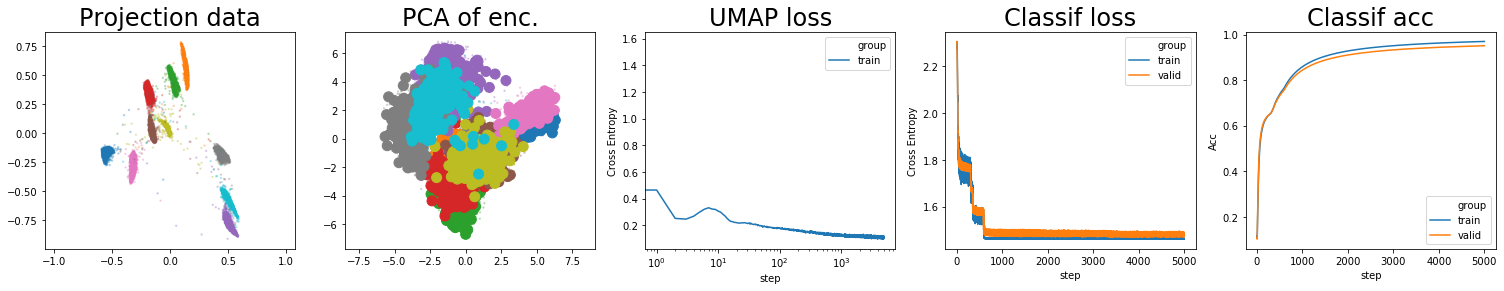

batch: 5000 | train acc: 0.9705 | val acc: 0.9516
saving weights | batch = 5000 | acc = 95


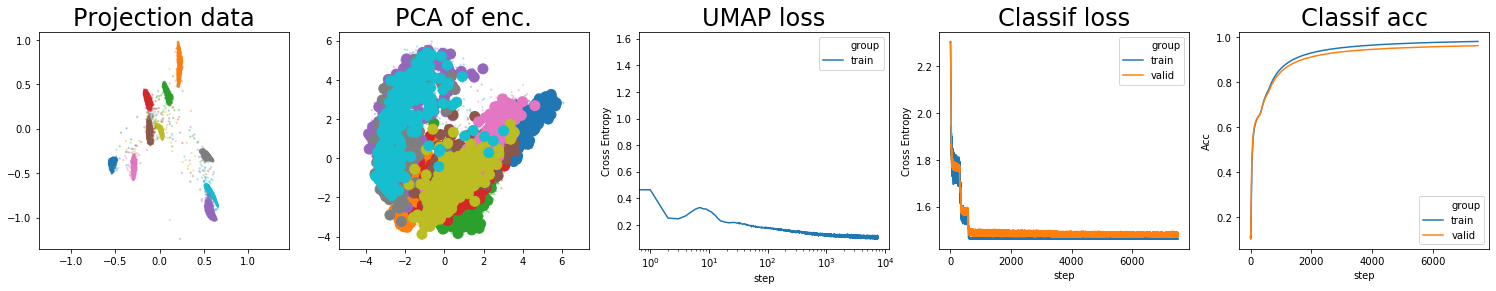

batch: 7500 | train acc: 0.9798 | val acc: 0.9608
saving weights | batch = 7500 | acc = 96


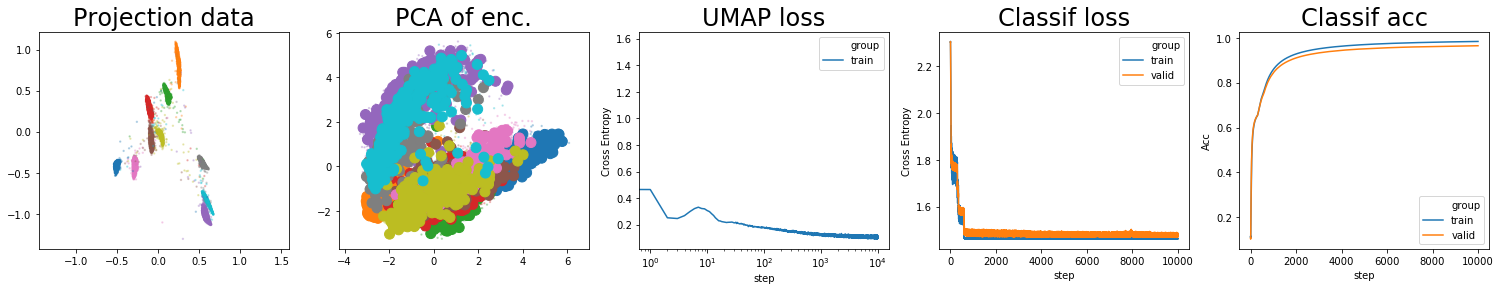

batch: 10000 | train acc: 0.9845 | val acc: 0.9653
saving weights | batch = 10000 | acc = 96


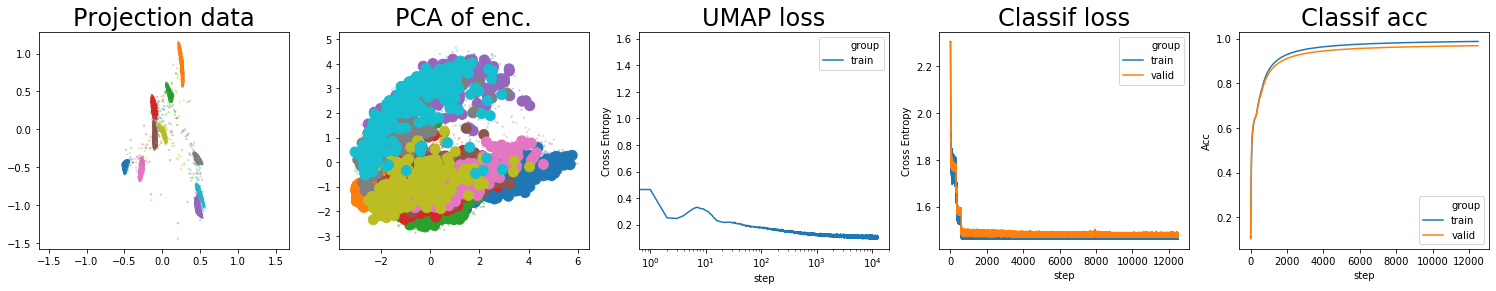

batch: 12500 | train acc: 0.9874 | val acc: 0.9683
saving weights | batch = 12500 | acc = 96


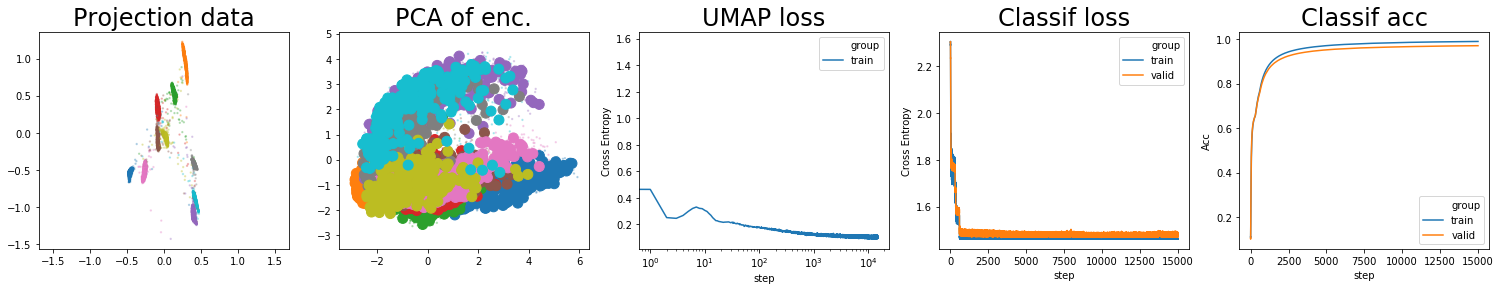

batch: 15000 | train acc: 0.9893 | val acc: 0.9702
saving weights | batch = 15000 | acc = 97


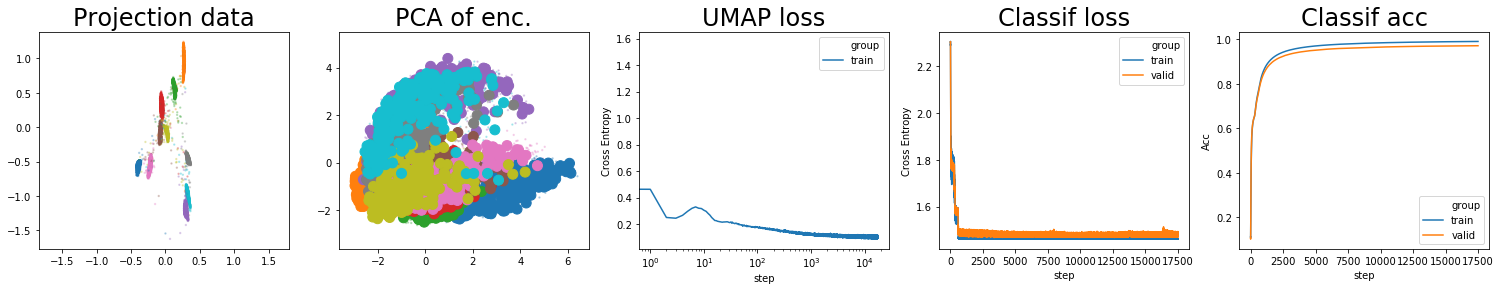

batch: 17500 | train acc: 0.9906 | val acc: 0.9714
saving weights | batch = 17500 | acc = 97


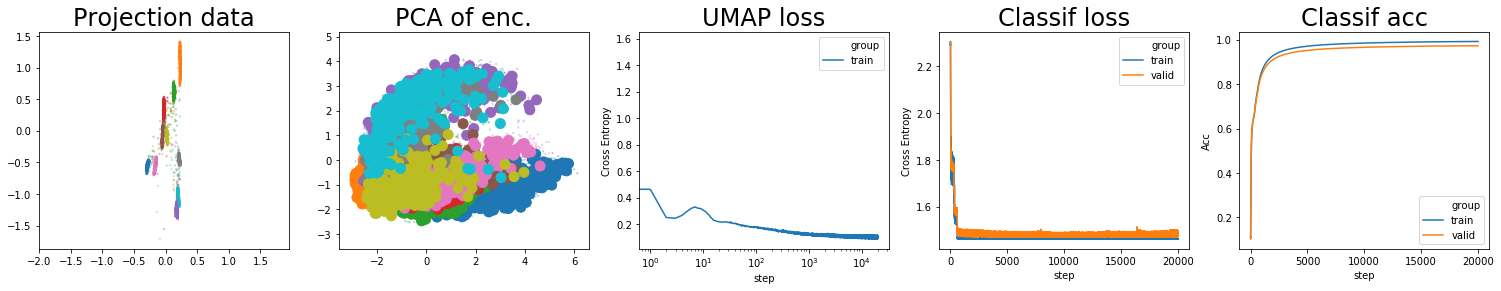

batch: 20000 | train acc: 0.9917 | val acc: 0.9722
saving weights | batch = 20000 | acc = 97


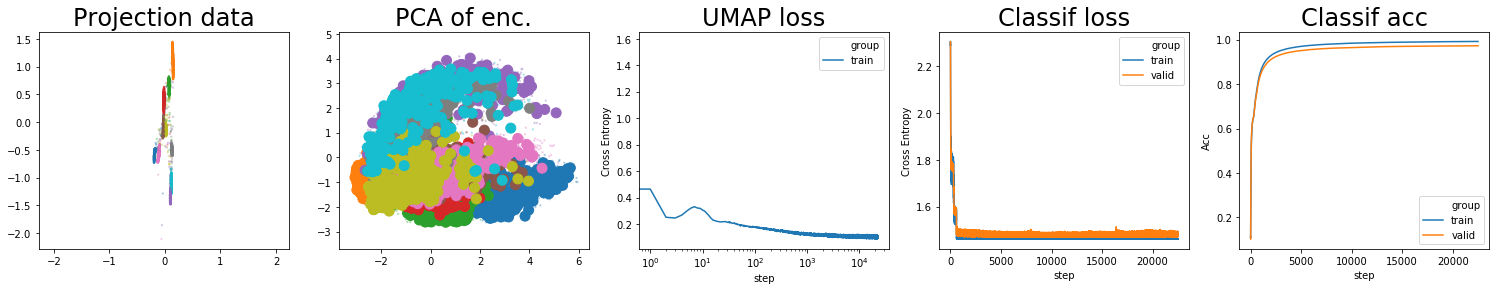

batch: 22500 | train acc: 0.9925 | val acc: 0.9729
saving weights | batch = 22500 | acc = 97


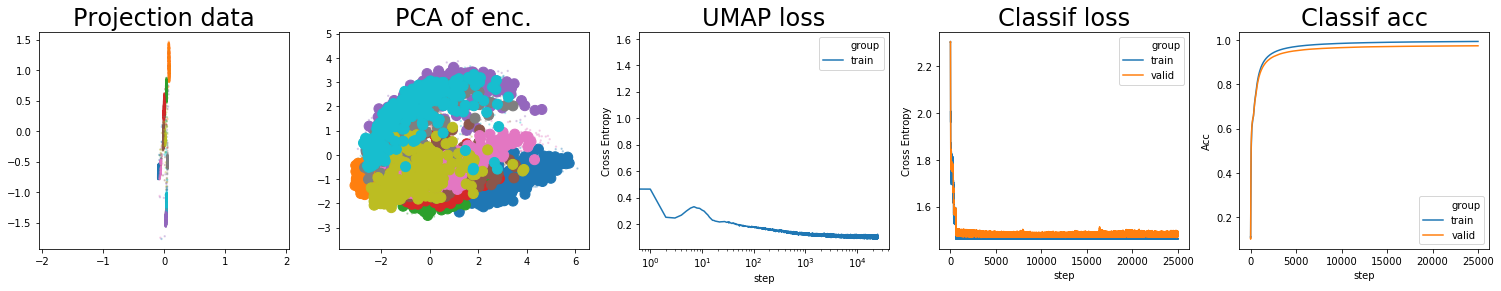

batch: 25000 | train acc: 0.9931 | val acc: 0.9735
saving weights | batch = 25000 | acc = 97


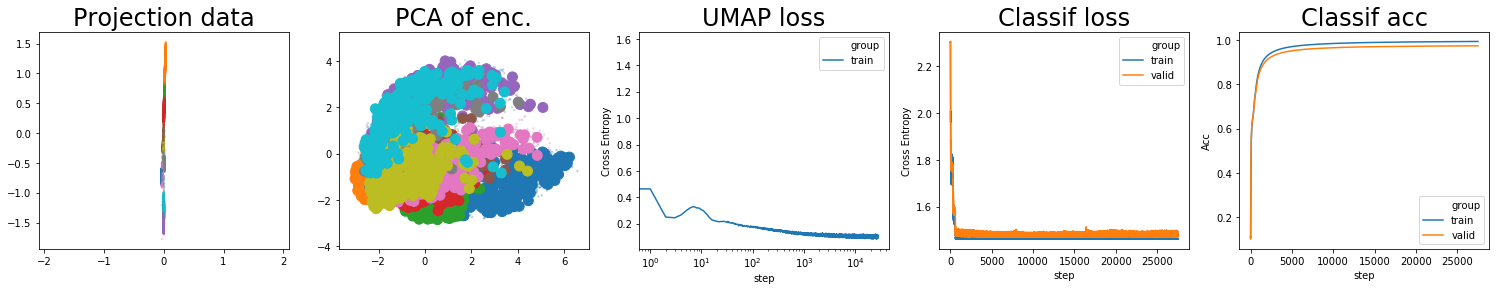

batch: 27500 | train acc: 0.9937 | val acc: 0.974
saving weights | batch = 27500 | acc = 97


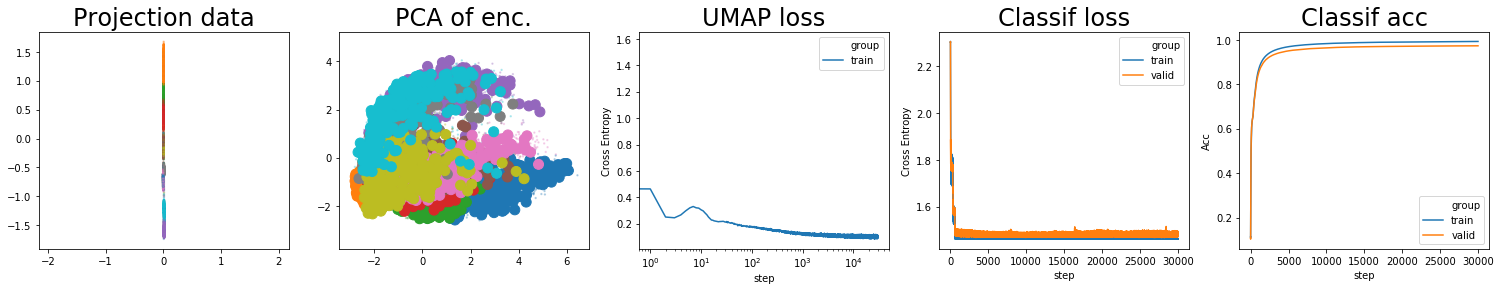

batch: 30000 | train acc: 0.9941 | val acc: 0.9744
saving weights | batch = 30000 | acc = 97


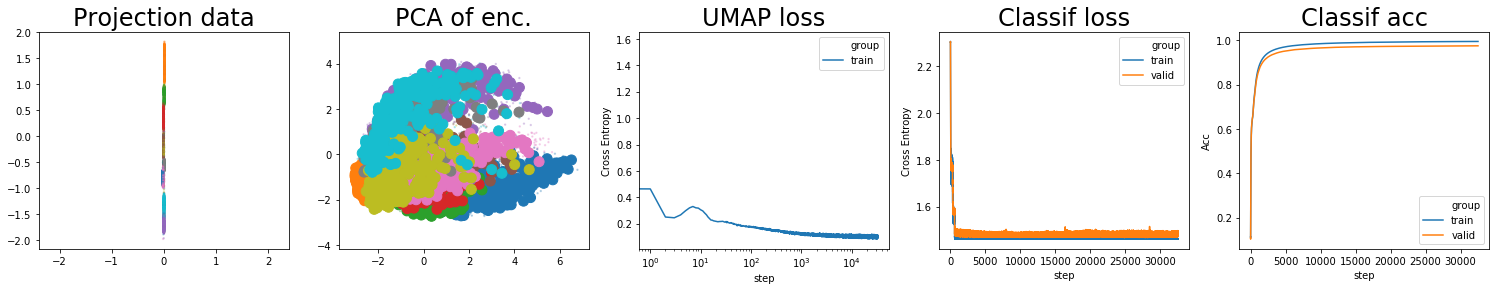

batch: 32500 | train acc: 0.9945 | val acc: 0.9747
saving weights | batch = 32500 | acc = 97


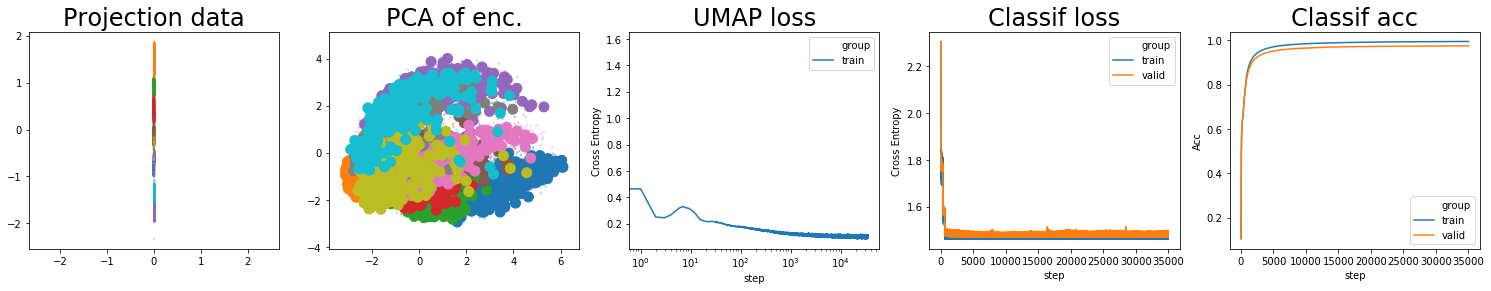

batch: 35000 | train acc: 0.9948 | val acc: 0.9749
saving weights | batch = 35000 | acc = 97


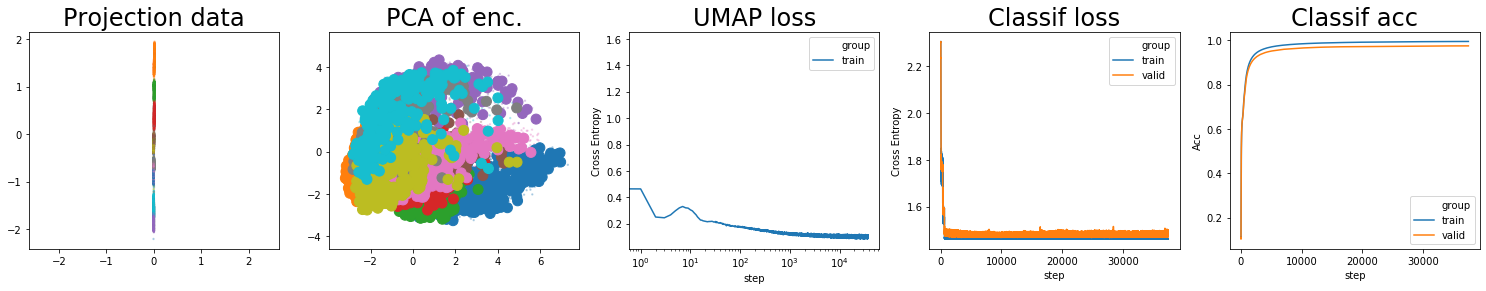

batch: 37500 | train acc: 0.9951 | val acc: 0.9751
saving weights | batch = 37500 | acc = 97


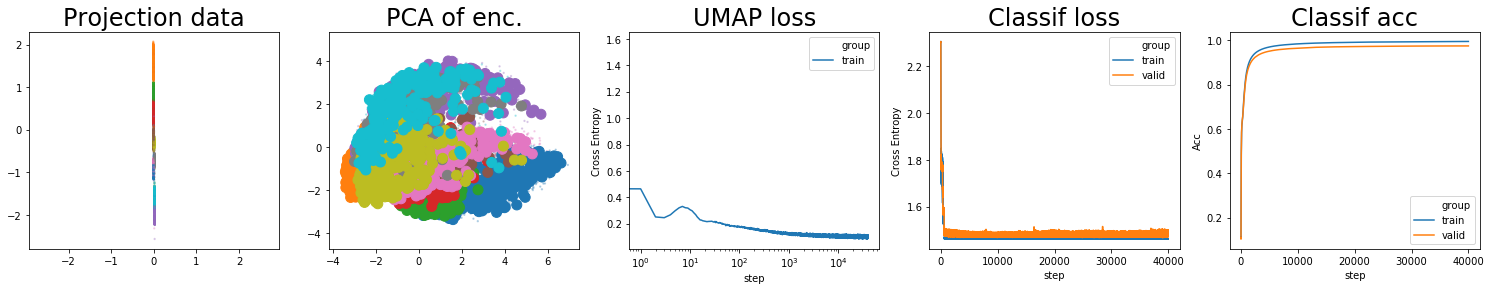

batch: 40000 | train acc: 0.9954 | val acc: 0.9751
saving weights | batch = 40000 | acc = 97


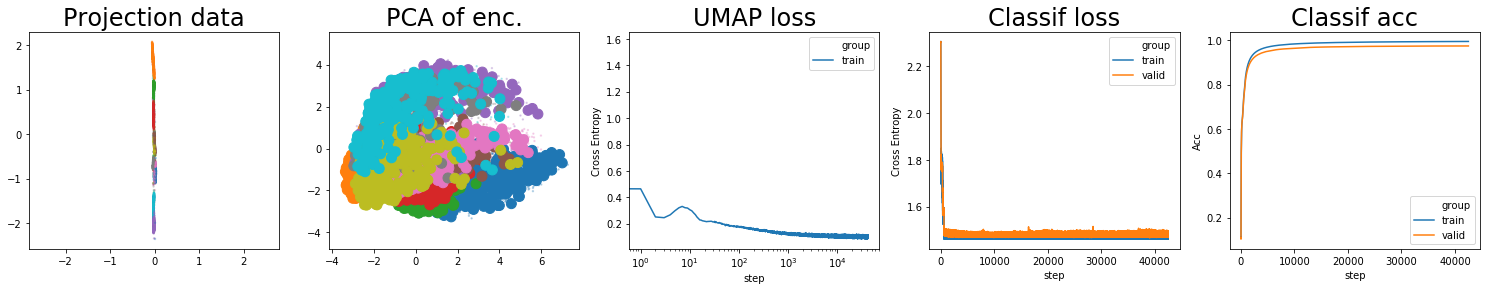

batch: 42500 | train acc: 0.9957 | val acc: 0.9752
saving weights | batch = 42500 | acc = 97


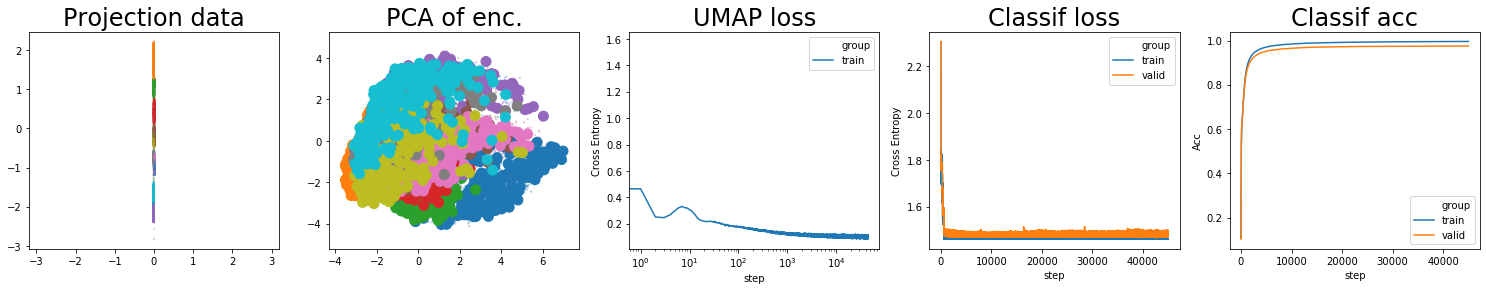

batch: 45000 | train acc: 0.9959 | val acc: 0.9753
saving weights | batch = 45000 | acc = 97


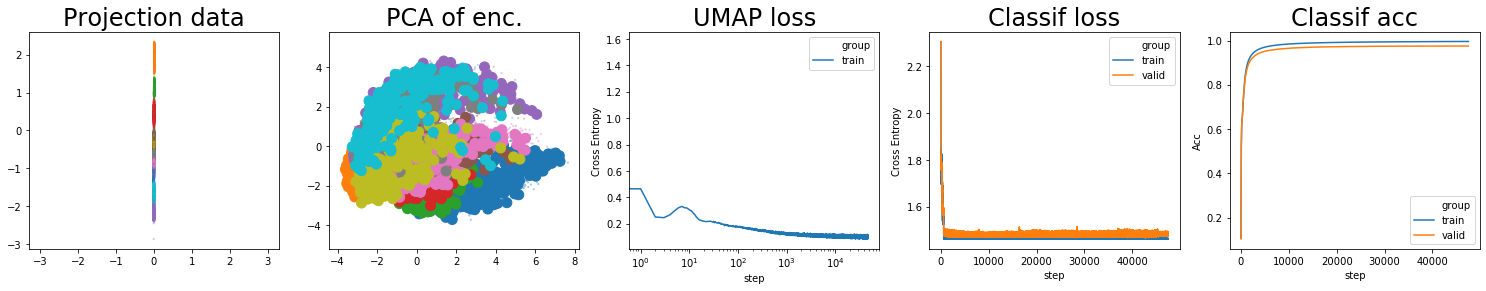

batch: 47500 | train acc: 0.9961 | val acc: 0.9754
saving weights | batch = 47500 | acc = 97


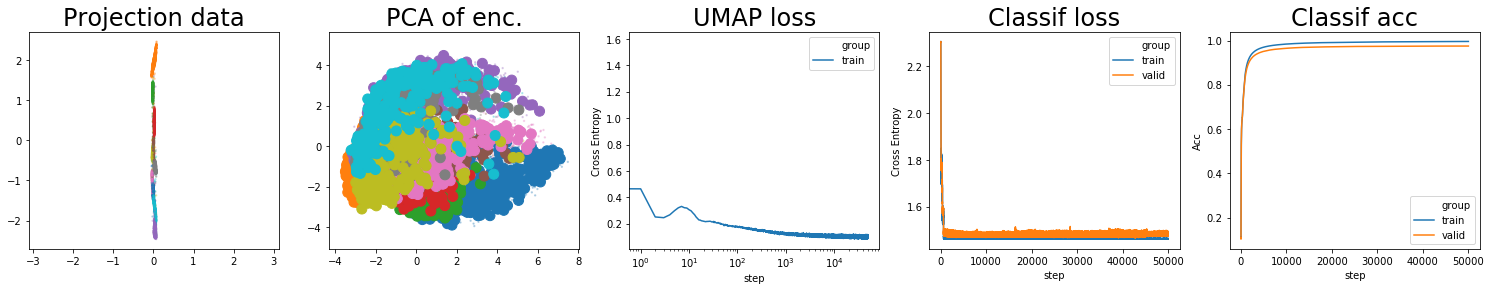

batch: 50000 | train acc: 0.9963 | val acc: 0.9755
saving weights | batch = 50000 | acc = 97


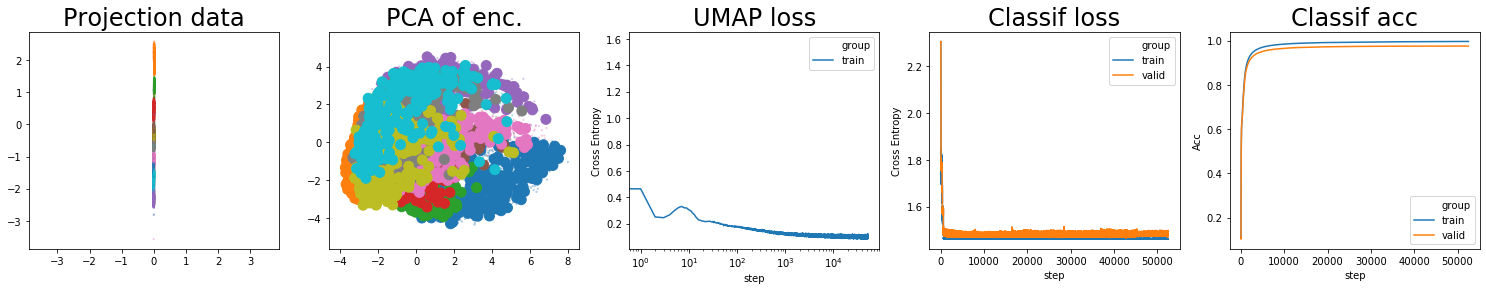

batch: 52500 | train acc: 0.9965 | val acc: 0.9756
saving weights | batch = 52500 | acc = 97


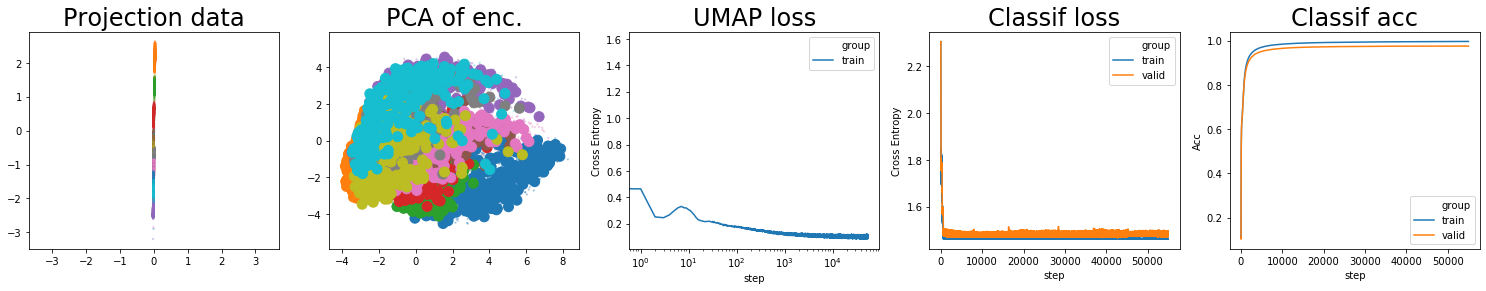

batch: 55000 | train acc: 0.9966 | val acc: 0.9757
saving weights | batch = 55000 | acc = 97


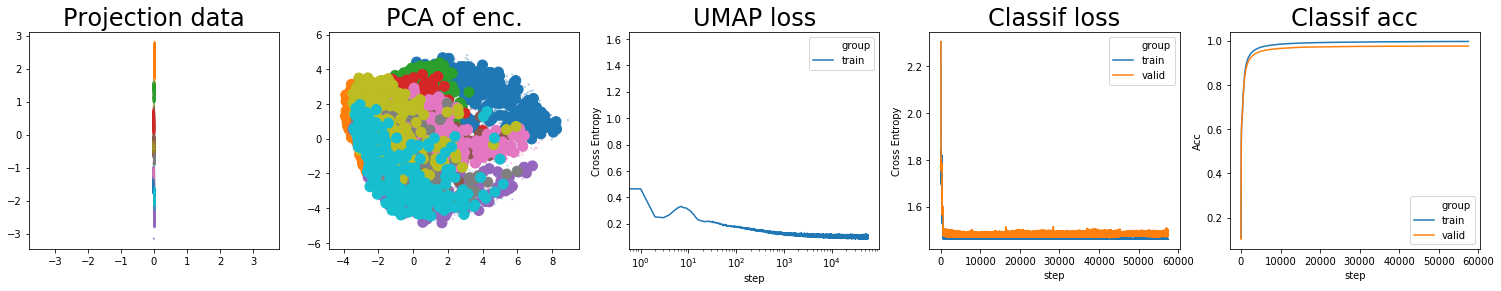

batch: 57500 | train acc: 0.9968 | val acc: 0.9757
saving weights | batch = 57500 | acc = 97


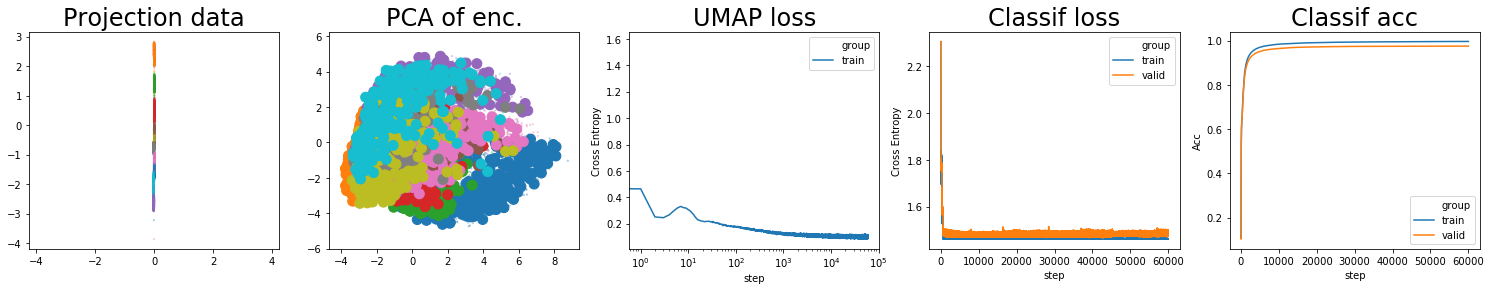

batch: 60000 | train acc: 0.9969 | val acc: 0.9757


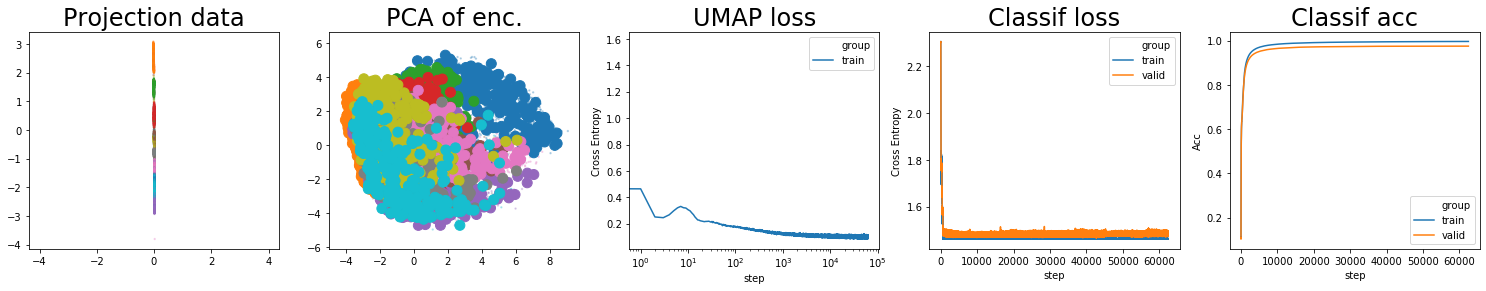

batch: 62500 | train acc: 0.997 | val acc: 0.9757
saving weights | batch = 62500 | acc = 97


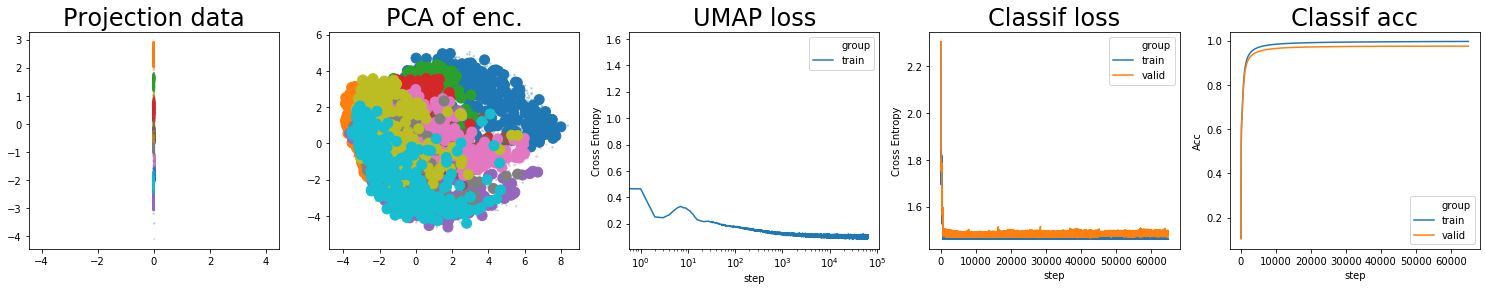

batch: 65000 | train acc: 0.9971 | val acc: 0.9758
saving weights | batch = 65000 | acc = 97


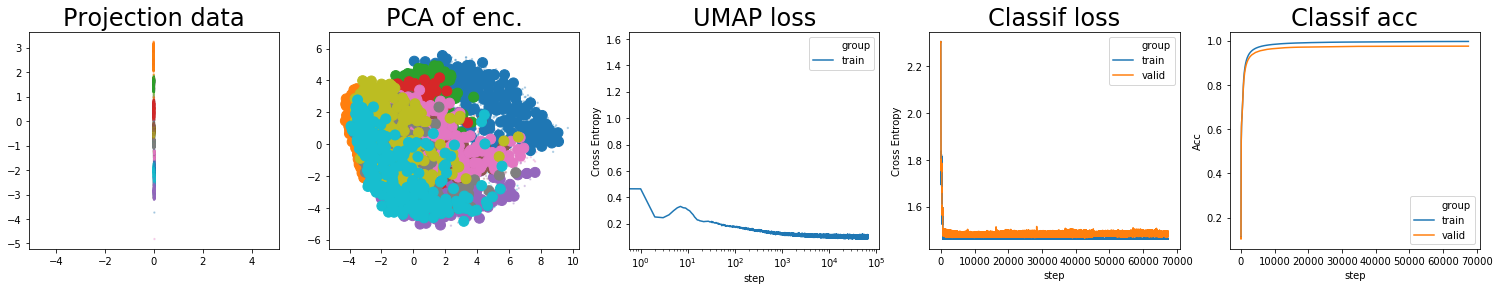

batch: 67500 | train acc: 0.9972 | val acc: 0.9759
saving weights | batch = 67500 | acc = 97


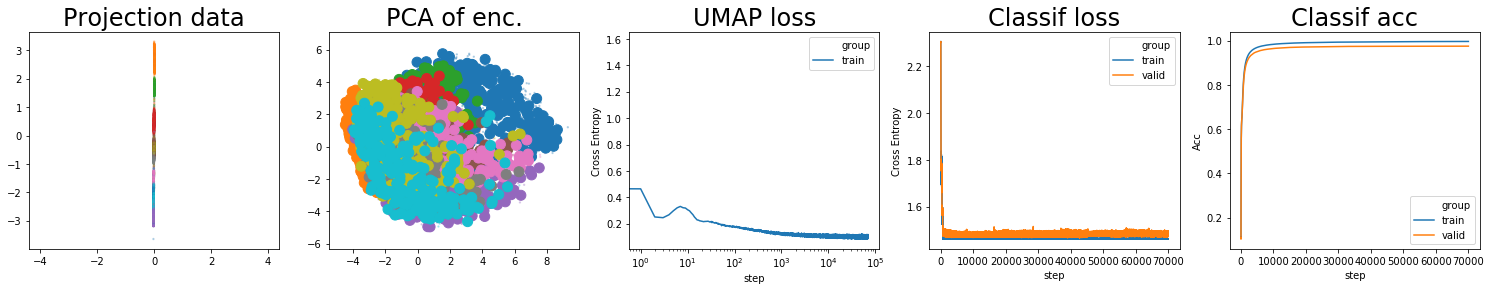

batch: 70000 | train acc: 0.9973 | val acc: 0.976
saving weights | batch = 70000 | acc = 97


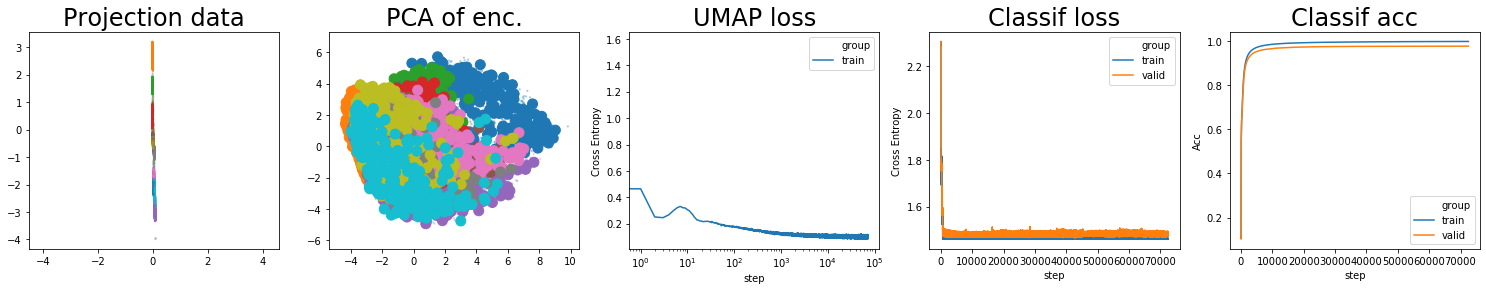

batch: 72500 | train acc: 0.9974 | val acc: 0.976
saving weights | batch = 72500 | acc = 97


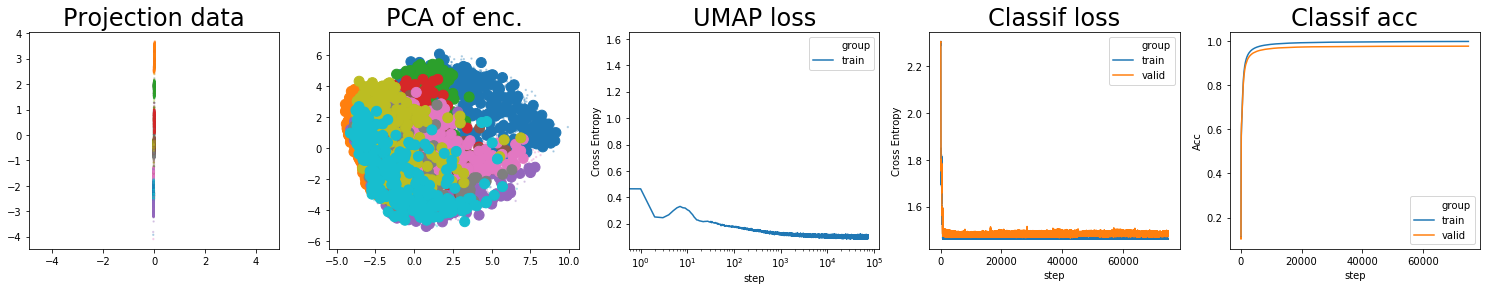

batch: 75000 | train acc: 0.9975 | val acc: 0.9761
saving weights | batch = 75000 | acc = 97


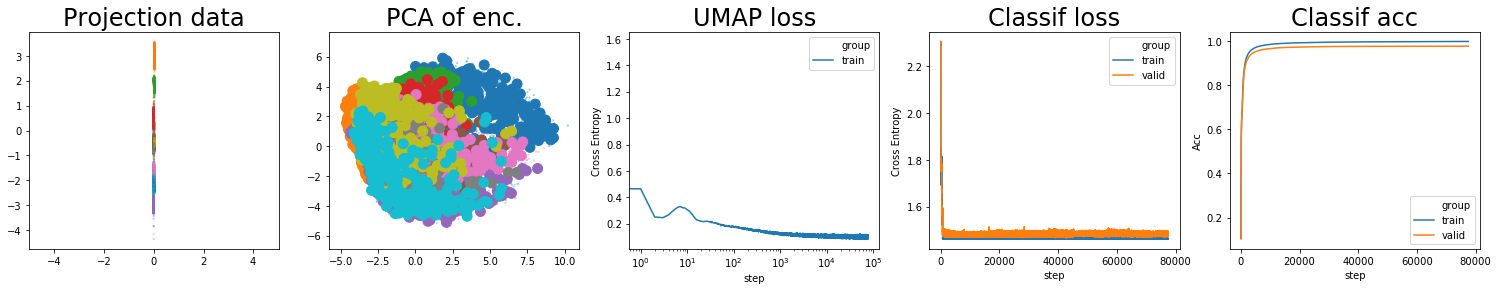

batch: 77500 | train acc: 0.9976 | val acc: 0.9761
saving weights | batch = 77500 | acc = 97


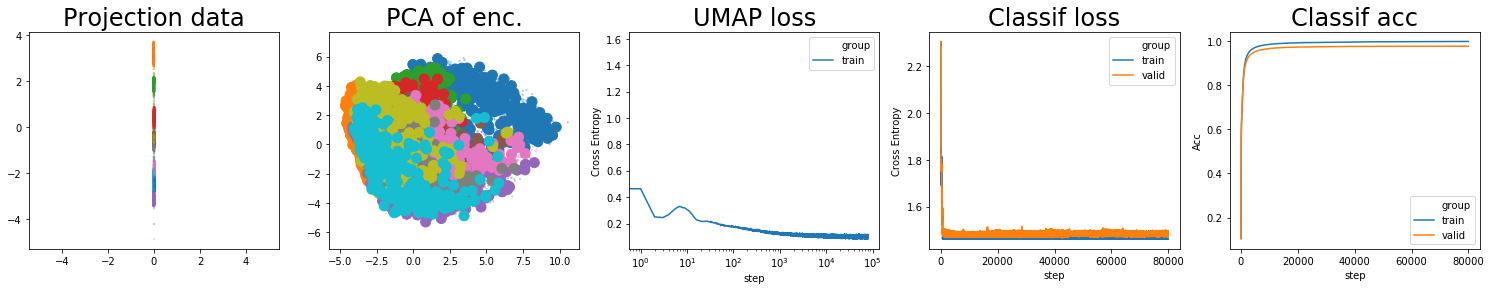

batch: 80000 | train acc: 0.9976 | val acc: 0.9762
saving weights | batch = 80000 | acc = 97


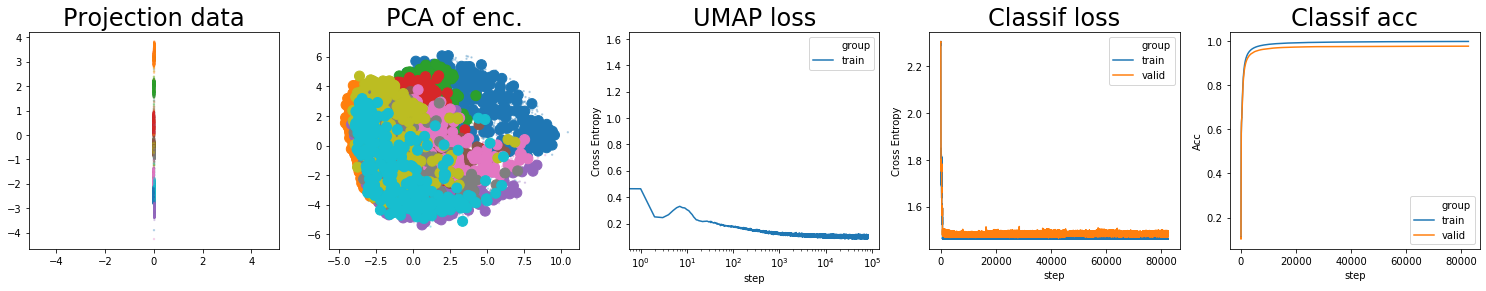

batch: 82500 | train acc: 0.9977 | val acc: 0.9763
saving weights | batch = 82500 | acc = 97


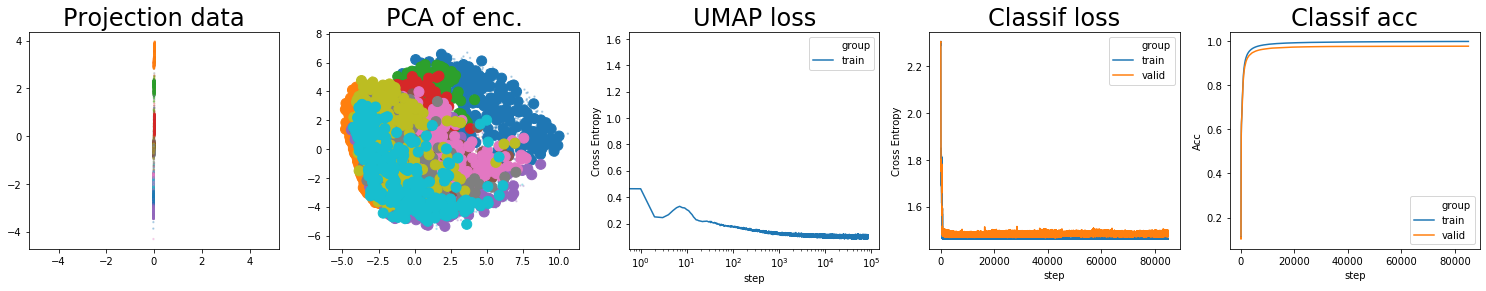

batch: 85000 | train acc: 0.9978 | val acc: 0.9763


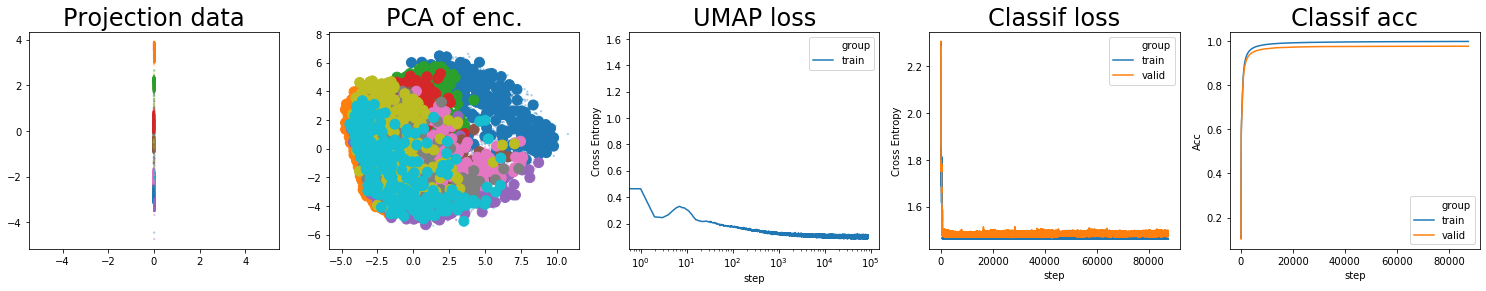

batch: 87500 | train acc: 0.9978 | val acc: 0.9762


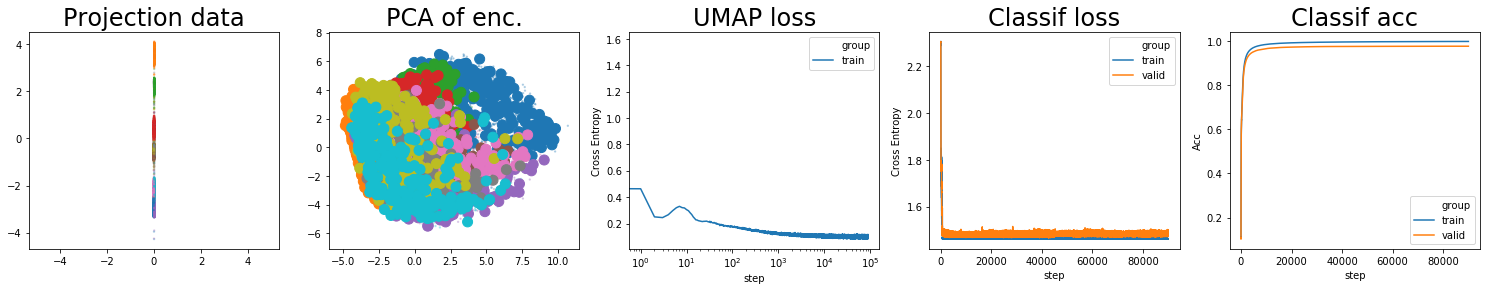

batch: 90000 | train acc: 0.9979 | val acc: 0.9763


Early stopping


In [29]:
for edge_epoch, epoch in tqdm(zip(edge_iter, np.arange(N_EPOCHS)), total=N_EPOCHS, desc = 'epoch'):
    for (batch_to, batch_from), (X, y), (X_val, y_val) in tqdm(
        zip(edge_epoch, labeled_iter, data_valid), total=BATCHES_PER_EPOCH, leave=False, desc = 'batch'
    ):

        # train
        (
            attraction_loss,
            repellant_loss,
            umap_loss,
            classifier_loss,
            classifier_acc,
        ) = model.train(
            batch_to=X_train[batch_to], batch_from=X_train[batch_from], X=X, y=y
        )

        # compute validation loss
        val_loss, val_acc = compute_classifier_loss(
            X_val,
            y_val,
            model.encoder,
            model.classifier,
            model.sparse_ce,
            model.class_acc_val,
        )

        # save losses
        model.write_losses(
            tf.convert_to_tensor(batch, dtype=tf.int64),
            classifier_acc,
            classifier_loss,
            umap_loss,
            val_loss,
            val_acc,
        )

        # plot results
        if batch % plot_frequency == 0:
            plot_umap_classif_results(
                model,
                X_valid,
                Y_valid,
                X_train,
                X_labeled,
                Y_labeled,
                batch_size,
                cmap="tab10",
                cmap2="tab10",
            )
            print(
                "batch: {} | train acc: {} | val acc: {}".format(
                    str(batch),
                    str(round(classifier_acc.numpy(), 4)),
                    str(round(val_acc.numpy(), 4)),
                )
            )

        #### save network
        if batch % save_frequency == 0:
            if val_acc > best_saved_acc:
                # save weights
                print("saving weights | batch = {} | acc = {}".format(batch, int(val_acc * 100)))
                model.encoder.save_weights((cpt_path / "encoder").as_posix())
                model.embedder.save_weights((cpt_path / "embedder").as_posix())
                model.classifier.save_weights((cpt_path / "classifier").as_posix())
                best_saved_acc = val_acc.numpy()
                # save batch number
                best_saved_batch = copy.deepcopy(batch)

        if val_acc < (best_saved_acc - max_reinitialize_delta):
            lr = model.optimizer.lr.numpy()
            # reload weights
            print(
                "batch {} | acc = {} | learn rate = {} | reloading weights from batch {} at acc {} | n reloads = {}".format(
                    batch, str(round(val_acc.numpy(),3)), lr, best_saved_batch, int(best_saved_acc * 100), n_reloads
                )
            )

            plot_umap_classif_results(
                model,
                X_valid,
                Y_valid,
                X_train,
                X_labeled,
                Y_labeled,
                batch_size,
                cmap="tab10",
                cmap2="tab10",
            )

            model.encoder.load_weights((cpt_path / "encoder").as_posix())
            model.embedder.load_weights((cpt_path / "embedder").as_posix())
            model.classifier.load_weights((cpt_path / "classifier").as_posix())

            # reset batch
            batch = copy.deepcopy(best_saved_batch)
            # reset optimizer
            for var in model.optimizer.variables():
                var.assign(tf.zeros_like(var))

            # set new learning rate
            model.optimizer.lr.assign(lr / 2)

            batch += 1
            n_reloads += 1

            # stop if reloaded too many times
            if n_reloads >= max_reloads:
                break
                early_stopping = True

            model.class_acc.reset_states()
            model.class_acc_val.reset_states()
            # continue on with newly updated batch (past early stopping)
            continue

        #### early stopping
        # if there is an imporovement, set new best score
        if val_acc > best_acc + min_delta:
            last_improvement = 0
            best_acc = val_acc
        else:
            # if model has not improved and patience has been surpassed, quit
            if last_improvement >= patience:
                print("Early stopping")
                early_stopping = True
                break
            else:
                last_improvement += 1

        batch += 1
    if early_stopping:
        break
    if n_reloads >= max_reloads:
        break

### Save results

In [30]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

from tfumap.semisupervised_plotting import embed_data

loss_df = retrieve_tensors(model.tensorboard_logdir)
loss_df['step'] +=1
loss_df

,wall_time,step,val,group,variable
0,1.596177e+09,1,0.113000,train,classif_acc
1,1.596177e+09,2,0.116500,train,classif_acc
2,1.596177e+09,3,0.109000,train,classif_acc
3,1.596177e+09,4,0.113250,train,classif_acc
4,1.596177e+09,5,0.115200,train,classif_acc
...,...,...,...,...,...
91346,1.596190e+09,91347,1.490506,valid,classif_loss
91347,1.596190e+09,91348,1.484201,valid,classif_loss
91348,1.596190e+09,91349,1.475468,valid,classif_loss
91349,1.596190e+09,91350,1.478897,valid,classif_loss


In [31]:
loss_df.to_pickle(cpt_path / 'loss_df.pickle')

In [32]:
valid_acc = loss_df[
    (loss_df.group.values == "valid") & (loss_df.variable.values == "classif_acc")
].val.values

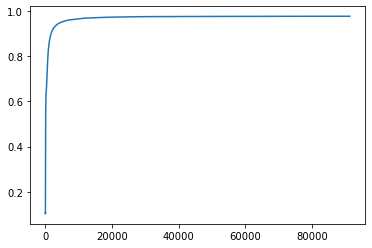

In [33]:
plt.plot(valid_acc)

In [34]:
y_pred = [model.classifier(model.encoder(np.expand_dims(i, 0))) for i in tqdm(X_test)]
y_pred = np.vstack(y_pred)

In [35]:
test_acc = tf.keras.metrics.sparse_categorical_accuracy(
    Y_test, y_pred
).numpy()
print(np.mean(test_acc))

0.9726


In [36]:
np.save(cpt_path / 'test_acc.npy', test_acc)